In [1]:
import sys 
# sys.path.clear()
sys.path.insert(0, 'D:\\Anaconda\\envs\\tensorflow_cpu\\python36.zip')
sys.path.insert(0, 'D:\\Anaconda\\envs\\tensorflow_cpu\\DLLs')
sys.path.insert(0, 'D:\\Anaconda\\envs\\tensorflow_cpu\\lib')
sys.path.insert(0, 'D:\\Anaconda\\envs\\tensorflow_cpu')
sys.path.insert(0, 'D:\\Anaconda\\envs\\tensorflow_cpu\\lib\\site-packages')
sys.path.insert(0, '')

In [6]:
sys.path

['',
 'D:\\Anaconda\\envs\\tensorflow_cpu\\lib\\site-packages',
 'D:\\Anaconda\\envs\\tensorflow_cpu',
 'D:\\Anaconda\\envs\\tensorflow_cpu\\lib',
 'D:\\Anaconda\\envs\\tensorflow_cpu\\DLLs',
 'D:\\Anaconda\\envs\\tensorflow_cpu\\python36.zip',
 '',
 'D:\\Anaconda\\python36.zip',
 'D:\\Anaconda\\DLLs',
 'D:\\Anaconda\\lib',
 'D:\\Anaconda',
 'D:\\Anaconda\\lib\\site-packages',
 'D:\\Anaconda\\lib\\site-packages\\Sphinx-1.5.6-py3.6.egg',
 'D:\\Anaconda\\lib\\site-packages\\win32',
 'D:\\Anaconda\\lib\\site-packages\\win32\\lib',
 'D:\\Anaconda\\lib\\site-packages\\Pythonwin',
 'D:\\Anaconda\\lib\\site-packages\\setuptools-27.2.0-py3.6.egg',
 'D:\\Anaconda\\lib\\site-packages\\IPython\\extensions',
 'C:\\Users\\Litos\\.ipython']

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.0.0


In [3]:
from scipy.sparse import csr_matrix, load_npz, save_npz
from tqdm import tqdm
from sklearn.preprocessing import normalize
import datetime
import json
import pandas as pd
import time
import yaml
import scipy.sparse as sparse
from ast import literal_eval

# Load data

In [4]:
# Load Original Data
df_train = pd.read_csv('../../data/yelp/Train.csv',encoding='latin-1')
df_valid = pd.read_csv('../../data/yelp/Valid.csv',encoding='latin-1')
df_test = pd.read_csv('../../data/yelp/Test.csv',encoding='latin-1')
keyphrases = pd.read_csv('../../data/yelp/KeyPhrases.csv')['Phrases'].tolist()

In [6]:
def to_sparse_matrix(df, num_user, num_item, user_col, item_col, rating_col):

    dok = df[[user_col, item_col, rating_col]].copy()
    dok = dok.values
    dok = dok[dok[:, 2] > 0]
    shape = [num_user, num_item]
    return sparse.csr_matrix((dok[:, 2].astype(np.float32), (dok[:, 0], dok[:, 1])), shape=shape)

def generate_sparse():
#     num_users = df_train['UserIndex'].nunique()
#     num_items = df_train['ItemIndex'].nunique()
    num_users = df_train['UserIndex'].max() + 1
    num_items = df_train['ItemIndex'].max() + 1
    R_train = to_sparse_matrix(df_train, num_users, num_items, 'UserIndex', 'ItemIndex', rating_col)
    sparse.save_npz('../../data/yelp/' + 'Rtrain.npz', R_train)
    
    R_valid = to_sparse_matrix(df_valid, num_users, num_items, 'UserIndex','ItemIndex', rating_col)
    sparse.save_npz('../../data/yelp/' + 'Rvalid.npz', R_valid)
    
    R_test = to_sparse_matrix(df_test, num_users, num_items, 'UserIndex', 'ItemIndex', rating_col)
    sparse.save_npz('../../data/yelp/' + 'Rtest.npz', R_test)

In [9]:
df_train['ItemIndex'].max()

7455

In [10]:
df_train['UserIndex'].nunique()

2191

In [11]:
df_train['UserIndex'].max()

2342

In [12]:
rating_col = 'rating'
generate_sparse()

In [6]:
# Load U-I Data 
rtrain = load_npz("../../data/yelp/Rtrain.npz")
rvalid = load_npz("../../data/yelp/Rvalid.npz")
rtest = load_npz("../../data/yelp/Rtest.npz")

In [7]:
rtrain

<2343x7456 sparse matrix of type '<class 'numpy.float32'>'
	with 95153 stored elements in Compressed Sparse Row format>

# Models

In [8]:
# Models
from sklearn.metrics.pairwise import cosine_similarity
def train(matrix_train):
    similarity = cosine_similarity(X=matrix_train, Y=None, dense_output=True)
    return similarity

def get_I_K(df, row_name = 'ItemIndex', shape = (3668,75)):
    rows = []
    cols = []
    vals = []
    for i in tqdm(range(df.shape[0])):
        key_vector = literal_eval(df['keyVector'][i])
        rows.extend([df[row_name][i]]*len(key_vector)) ## Item index
        cols.extend(key_vector) ## Keyword Index
        vals.extend(np.array([1]*len(key_vector)))
    return csr_matrix((vals, (rows, cols)), shape=shape)

def predict(matrix_train, k, similarity, item_similarity_en = False):
    """
    res = similarity * matrix_train    if item_similarity_en = False
    res = similarity * matrix_train.T  if item_similarity_en = True
    """
    prediction_scores = []
    
    if item_similarity_en:
        matrix_train = matrix_train.transpose()
        
    for user_index in tqdm(range(matrix_train.shape[0])):
        # Get user u's prediction scores to all users
        vector_u = similarity[user_index]

        # Get closest K neighbors excluding user u self
        similar_users = vector_u.argsort()[::-1][1:k+1]
        # Get neighbors similarity weights and ratings
        similar_users_weights = similarity[user_index][similar_users]
        similar_users_ratings = matrix_train[similar_users].toarray()

        prediction_scores_u = similar_users_ratings * similar_users_weights[:, np.newaxis]

        prediction_scores.append(np.sum(prediction_scores_u, axis=0))
    res = np.array(prediction_scores)
    
    if item_similarity_en:
        res = res.transpose()
    
    return res

def prediction(prediction_score, topK, matrix_Train):

    prediction = []

    for user_index in tqdm(range(matrix_Train.shape[0])):
        vector_u = prediction_score[user_index]
        vector_train = matrix_Train[user_index]
        if len(vector_train.nonzero()[0]) > 0:
            vector_predict = sub_routine(vector_u, vector_train, topK=topK)
        else:
            vector_predict = np.zeros(topK, dtype=np.float32)

        prediction.append(vector_predict)

    return np.vstack(prediction)


def sub_routine(vector_u, vector_train, topK=500):

    train_index = vector_train.nonzero()[1]

    vector_u = vector_u

    candidate_index = np.argpartition(-vector_u, topK+len(train_index))[:topK+len(train_index)]
    vector_u = candidate_index[vector_u[candidate_index].argsort()[::-1]]
    vector_u = np.delete(vector_u, np.isin(vector_u, train_index).nonzero()[0])

    return vector_u[:topK]


In [9]:
# Evluation 
def recallk(vector_true_dense, hits, **unused):
    hits = len(hits.nonzero()[0])
    return float(hits)/len(vector_true_dense)

def precisionk(vector_predict, hits, **unused):
    hits = len(hits.nonzero()[0])
    return float(hits)/len(vector_predict)


def average_precisionk(vector_predict, hits, **unused):
    precisions = np.cumsum(hits, dtype=np.float32)/range(1, len(vector_predict)+1)
    return np.mean(precisions)


def r_precision(vector_true_dense, vector_predict, **unused):
    vector_predict_short = vector_predict[:len(vector_true_dense)]
    hits = len(np.isin(vector_predict_short, vector_true_dense).nonzero()[0])
    return float(hits)/len(vector_true_dense)


def _dcg_support(size):
    arr = np.arange(1, size+1)+1
    return 1./np.log2(arr)


def ndcg(vector_true_dense, vector_predict, hits):
    idcg = np.sum(_dcg_support(len(vector_true_dense)))
    dcg_base = _dcg_support(len(vector_predict))
    dcg_base[np.logical_not(hits)] = 0
    dcg = np.sum(dcg_base)
    return dcg/idcg


def click(hits, **unused):
    first_hit = next((i for i, x in enumerate(hits) if x), None)
    if first_hit is None:
        return 5
    else:
        return first_hit/10


def evaluate(matrix_Predict, matrix_Test, metric_names =['R-Precision', 'NDCG', 'Precision', 'Recall', 'MAP'], atK = [5, 10, 15, 20, 50], analytical=False):
    """
    :param matrix_U: Latent representations of users, for LRecs it is RQ, for ALSs it is U
    :param matrix_V: Latent representations of items, for LRecs it is Q, for ALSs it is V
    :param matrix_Train: Rating matrix for training, features.
    :param matrix_Test: Rating matrix for evaluation, true labels.
    :param k: Top K retrieval
    :param metric_names: Evaluation metrics
    :return:
    """
    global_metrics = {
        "R-Precision": r_precision,
        "NDCG": ndcg,
        "Clicks": click
    }

    local_metrics = {
        "Precision": precisionk,
        "Recall": recallk,
        "MAP": average_precisionk
    }

    output = dict()

    num_users = matrix_Predict.shape[0]

    for k in atK:

        local_metric_names = list(set(metric_names).intersection(local_metrics.keys()))
        results = {name: [] for name in local_metric_names}
        topK_Predict = matrix_Predict[:, :k]

        for user_index in tqdm(range(topK_Predict.shape[0])):
            vector_predict = topK_Predict[user_index]
            if len(vector_predict.nonzero()[0]) > 0:
                vector_true = matrix_Test[user_index]
                vector_true_dense = vector_true.nonzero()[1]
                hits = np.isin(vector_predict, vector_true_dense)

                if vector_true_dense.size > 0:
                    for name in local_metric_names:
                        results[name].append(local_metrics[name](vector_true_dense=vector_true_dense,
                                                                 vector_predict=vector_predict,
                                                                 hits=hits))

        results_summary = dict()
        if analytical:
            for name in local_metric_names:
                results_summary['{0}@{1}'.format(name, k)] = results[name]
        else:
            for name in local_metric_names:
                results_summary['{0}@{1}'.format(name, k)] = (np.average(results[name]),
                                                              1.96*np.std(results[name])/np.sqrt(num_users))
        output.update(results_summary)

    global_metric_names = list(set(metric_names).intersection(global_metrics.keys()))
    results = {name: [] for name in global_metric_names}

    topK_Predict = matrix_Predict[:]

    for user_index in tqdm(range(topK_Predict.shape[0])):
        vector_predict = topK_Predict[user_index]

        if len(vector_predict.nonzero()[0]) > 0:
            vector_true = matrix_Test[user_index]
            vector_true_dense = vector_true.nonzero()[1]
            hits = np.isin(vector_predict, vector_true_dense)

            # if user_index == 1:
            #     import ipdb;
            #     ipdb.set_trace()

            if vector_true_dense.size > 0:
                for name in global_metric_names:
                    results[name].append(global_metrics[name](vector_true_dense=vector_true_dense,
                                                              vector_predict=vector_predict,
                                                              hits=hits))

    results_summary = dict()
    if analytical:
        for name in global_metric_names:
            results_summary[name] = results[name]
    else:
        for name in global_metric_names:
            results_summary[name] = (np.average(results[name]), 1.96*np.std(results[name])/np.sqrt(num_users))
    output.update(results_summary)

    return output



In [10]:
rtrain

<2343x7456 sparse matrix of type '<class 'numpy.float32'>'
	with 95153 stored elements in Compressed Sparse Row format>

In [11]:
len(keyphrases)

235

In [14]:
# Generate U-K 
U_K = get_I_K(df_train, row_name = 'UserIndex', shape = (2343,235))

100%|███████████████████████████████████████████████████████████████████████████| 95153/95153 [04:33<00:00, 348.48it/s]


In [32]:
save_npz("../../data/yelp/U_K",U_K)

In [12]:
U_K = load_npz("../../data/yelp/U_K.npz")

In [194]:
# Generate I-K 
I_K = get_I_K(df_train, row_name = 'ItemIndex', shape = (7456,235))

100%|███████████████████████████████████████████████████████████████████████████| 95153/95153 [04:03<00:00, 391.29it/s]


In [196]:
save_npz("../../data/yelp/I_K",I_K)

In [13]:
I_K = load_npz("../../data/yelp/I_K.npz")

# U_I Result

In [53]:
similarity = normalize(train(rtrain))
user_item_prediction_score = predict(rtrain, 100, similarity, item_similarity_en= False)
user_item_predict = prediction(user_item_prediction_score, 50, rtrain)
user_item_res = evaluate(user_item_predict, rtest)

100%|████████████████████████████████████████████████████████████████████████████| 2343/2343 [00:00<00:00, 3882.90it/s]


In [54]:
# k = 100
user_item_res

{'MAP@10': (0.06333952750429245, 0.00455145183026277),
 'MAP@15': (0.05872249612550844, 0.0038121823597348156),
 'MAP@20': (0.055196280875748356, 0.003345258771111864),
 'MAP@5': (0.06940666362391602, 0.0060646277121995185),
 'MAP@50': (0.04436838784245958, 0.0022020570312340938),
 'NDCG': (0.09071795198195, 0.003803970590016347),
 'Precision@10': (0.05330899132816066, 0.0032544740534870857),
 'Precision@15': (0.04698006998326487, 0.0025622684368576416),
 'Precision@20': (0.043336376083979916, 0.002222006808632301),
 'Precision@5': (0.06462802373345505, 0.004754606217931856),
 'Precision@50': (0.032889091738931994, 0.0014317314500480152),
 'R-Precision': (0.048464138894968055, 0.0027869069242192506),
 'Recall@10': (0.04269615369598775, 0.0027831077562657665),
 'Recall@15': (0.05562887733868642, 0.0031389991916236284),
 'Recall@20': (0.0677664821917642, 0.003424484045821138),
 'Recall@5': (0.026408137823500974, 0.002191309117794643),
 'Recall@50': (0.12696642809611336, 0.004824188397130

### Recsys14 style normalization

In [56]:
similarity =train(rtrain)
similarity = normalize(similarity.T).T

In [57]:
user_item_prediction_score = predict(normalize(rtrain), 100, similarity, item_similarity_en= False)
user_item_predict = prediction(user_item_prediction_score, 50, rtrain)
user_item_res = evaluate(user_item_predict, rtest)

100%|████████████████████████████████████████████████████████████████████████████| 2343/2343 [00:00<00:00, 3851.27it/s]


In [58]:
user_item_res

{'MAP@10': (0.06370092659001833, 0.004556800214078768),
 'MAP@15': (0.059054675398810506, 0.0038016289715754833),
 'MAP@20': (0.055604339782743234, 0.0033408205027605008),
 'MAP@5': (0.07105431309904152, 0.006198900000542999),
 'MAP@50': (0.044528226214501844, 0.0022039132659122675),
 'NDCG': (0.09053317886655628, 0.0038034625149712706),
 'Precision@10': (0.05326335006846189, 0.0032268393531510787),
 'Precision@15': (0.0480754602160353, 0.0026394244210492745),
 'Precision@20': (0.04386125057051574, 0.0022541432349504993),
 'Precision@5': (0.061798265632131436, 0.004583417285455465),
 'Precision@50': (0.03297124600638977, 0.0014485014634401355),
 'R-Precision': (0.04779854921317674, 0.002693423071180068),
 'Recall@10': (0.041582539180156135, 0.002647782330163792),
 'Recall@15': (0.056391989896148215, 0.003169227471950738),
 'Recall@20': (0.06785713007089812, 0.0034282135104452384),
 'Recall@5': (0.024449264509783047, 0.0020154799928708326),
 'Recall@50': (0.1247707158596782, 0.004702420

# Unlearned

In [59]:
similarity = normalize(train(U_K))
unlearned_prediction_score = predict(rtrain, 100, similarity, item_similarity_en= False)
unlearned_predict = prediction(unlearned_prediction_score, 50, rtrain)
unlearned_res = evaluate(unlearned_predict, rtest)
unlearned_res

100%|████████████████████████████████████████████████████████████████████████████| 2343/2343 [00:00<00:00, 4085.69it/s]


{'MAP@10': (0.04616609796208153, 0.0037864359210289583),
 'MAP@15': (0.04342978960961617, 0.0031726331101981425),
 'MAP@20': (0.04132202221205415, 0.002792719589436067),
 'MAP@5': (0.05050205385668644, 0.00504479215759216),
 'MAP@50': (0.03404977623315559, 0.001862465024105411),
 'NDCG': (0.07053219505877557, 0.00334909199172866),
 'Precision@10': (0.03920584208124144, 0.002691758978691653),
 'Precision@15': (0.036695572797809224, 0.0022337200545543097),
 'Precision@20': (0.03409402099497946, 0.0019426780260705812),
 'Precision@5': (0.04701049748973072, 0.0038993152478885473),
 'Precision@50': (0.02596074851665906, 0.0012562675740487661),
 'R-Precision': (0.037593615050130605, 0.002441995632950046),
 'Recall@10': (0.03213938990141511, 0.002392993987580395),
 'Recall@15': (0.044561241825622634, 0.00282176676196221),
 'Recall@20': (0.05447875144420225, 0.0031513892251596727),
 'Recall@5': (0.01973991877110838, 0.00186028913456729),
 'Recall@50': (0.10065883793602966, 0.004400404987236048

### Recsys14 style normalization

In [60]:
similarity = train(U_K)
similarity = normalize(similarity.T).T
unlearned_prediction_score = predict(normalize(rtrain), 100, similarity, item_similarity_en= False)
unlearned_predict = prediction(unlearned_prediction_score, 50, rtrain)
unlearned_res = evaluate(unlearned_predict, rtest)
unlearned_res

100%|████████████████████████████████████████████████████████████████████████████| 2343/2343 [00:00<00:00, 3915.64it/s]


{'MAP@10': (0.046286431505509554, 0.0038460926768623858),
 'MAP@15': (0.043101291426257196, 0.0031901335149288296),
 'MAP@20': (0.040653442292212565, 0.0027930635298885286),
 'MAP@5': (0.05130838277803133, 0.005239203557595133),
 'MAP@50': (0.033150181198070255, 0.0018188894372221888),
 'NDCG': (0.06786482370839758, 0.003242372573834944),
 'Precision@10': (0.03952533089913282, 0.002674311227006322),
 'Precision@15': (0.035235052487448654, 0.0021701215837329688),
 'Precision@20': (0.0323368324965769, 0.0018556471705838693),
 'Precision@5': (0.045641259698767686, 0.0039067884830291085),
 'Precision@50': (0.024984025559105432, 0.0011703579502333073),
 'R-Precision': (0.036611736285640205, 0.0023451225795725126),
 'Recall@10': (0.03147223445649655, 0.00229544833074995),
 'Recall@15': (0.040725357784652964, 0.0026104679925674007),
 'Recall@20': (0.04973310760018437, 0.0029069880494074934),
 'Recall@5': (0.018900211900466236, 0.0018228095328281862),
 'Recall@50': (0.09532258187037224, 0.0041

# Learned with Linear Regression

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import normalize
from sklearn.linear_model import Ridge

In [15]:
X = normalize(U_K.todense())
y = normalize(train(rtrain))

In [62]:
clf = Ridge(alpha=0.1).fit(X, y)

In [63]:
lr_similarity = clf.predict(np.array(X))

In [64]:
similarity = lr_similarity
lr_prediction_score = predict(rtrain, 100, similarity, item_similarity_en= False)
lr_predict = prediction(lr_prediction_score, 50, rtrain)
lr_res = evaluate(lr_predict, rtest)

100%|████████████████████████████████████████████████████████████████████████████| 2343/2343 [00:00<00:00, 3975.08it/s]


In [65]:
lr_res

{'MAP@10': (0.0579191932364, 0.004337173760974245),
 'MAP@15': (0.05410621479539782, 0.0036420905948940153),
 'MAP@20': (0.0514113544178991, 0.00321063889760705),
 'MAP@5': (0.06349003499163244, 0.005785447754232044),
 'MAP@50': (0.04161249065006333, 0.0021296299920805146),
 'NDCG': (0.08514745492045937, 0.0037227182371916663),
 'Precision@10': (0.04906435417617526, 0.0030992493571670326),
 'Precision@15': (0.04533698463410924, 0.002564070020831653),
 'Precision@20': (0.04210406207211319, 0.002221280781856864),
 'Precision@5': (0.05942492012779552, 0.004510206593046768),
 'Precision@50': (0.030789593792788686, 0.0013693555346728124),
 'R-Precision': (0.04498034624026185, 0.002658267116070035),
 'Recall@10': (0.03907562491767253, 0.0026192096631670594),
 'Recall@15': (0.05420595429830032, 0.003173562295251404),
 'Recall@20': (0.06650439279850905, 0.003556459694516587),
 'Recall@5': (0.024423385789734176, 0.002051772794243629),
 'Recall@50': (0.11966359399827448, 0.0047284204524481906)}

### Recsys14 style normalization

In [66]:
similarity = lr_similarity
similarity = normalize(similarity.T).T
lr_prediction_score = predict(normalize(rtrain), 100, similarity, item_similarity_en= False)
lr_predict = prediction(lr_prediction_score, 50, rtrain)
lr_res = evaluate(lr_predict, rtest)

100%|████████████████████████████████████████████████████████████████████████████| 2343/2343 [00:00<00:00, 4106.88it/s]


In [67]:
lr_res

{'MAP@10': (0.053627719458390385, 0.004256517836080131),
 'MAP@15': (0.05034291029726904, 0.0035618909350839077),
 'MAP@20': (0.04781615485729063, 0.0031361924683084106),
 'MAP@5': (0.05951163852122318, 0.005744536719798424),
 'MAP@50': (0.03926394715340559, 0.0020976475198012305),
 'NDCG': (0.07923504928970157, 0.003596842109502567),
 'Precision@10': (0.04596074851665906, 0.003056233443712461),
 'Precision@15': (0.041929103909934574, 0.0024947793350315692),
 'Precision@20': (0.03920584208124144, 0.0021768408210327017),
 'Precision@5': (0.05120949338201734, 0.0042356655365392865),
 'Precision@50': (0.02964856230031949, 0.0014050395633547145),
 'R-Precision': (0.04084470847747212, 0.002536196891555325),
 'Recall@10': (0.035358653396231995, 0.0024698265714274232),
 'Recall@15': (0.0486306529804357, 0.0029998576924290658),
 'Recall@20': (0.060313196096256294, 0.0033697953679102345),
 'Recall@5': (0.020403258434140918, 0.0019006714565957018),
 'Recall@50': (0.11165103505822944, 0.004581334

### Linear Regression Tuning

In [196]:
clf = Ridge(alpha=0.001).fit(X, y)

In [26]:
alpha_list = [1e-5, 1e-4, 1e-3, 1e-2, 0.1, 1, 10, 10e1, 10e2, 10e3, 10e4]

In [214]:
def tune_ridge(X, y, rtrain, rvalid, alpha_list):
    tuning_res = []
    for alpha in alpha_list:
        clf = Ridge(alpha=alpha).fit(X, y)
        lr_similarity = clf.predict(np.array(X))
        lr_prediction_score = predict(rtrain, 100, lr_similarity, item_similarity_en= False)
        lr_predict = prediction(lr_prediction_score, 50, rtrain)
        lr_res = evaluate(lr_predict, rvalid)
        print ('current alpha: ',alpha, ', ndcg is: ',lr_res['NDCG'])
        tuning_res.append(lr_res)
    return tuning_res

In [ ]:
tuning_res = tune_ridge(X, y, rtrain, rvalid, alpha_list)

In [25]:
tuning_res

[{'MAP@10': (0.04805285692551781, 0.003920472733145397),
  'MAP@15': (0.04478661254562669, 0.0032521352364207534),
  'MAP@20': (0.04222788103154307, 0.0028366138847246646),
  'MAP@5': (0.05272782595466301, 0.005321405124878171),
  'MAP@50': (0.03409391764848641, 0.0018218910300791065),
  'NDCG': (0.07999846961007356, 0.003667573156475868),
  'Precision@10': (0.040529438612505714, 0.0027466305158265897),
  'Precision@15': (0.0368172828236726, 0.0021988964610603003),
  'Precision@20': (0.033637608397991785, 0.0018635893937487664),
  'Precision@5': (0.048288452761296216, 0.004032639600205658),
  'Precision@50': (0.025330899132816064, 0.0011567750212765242),
  'R-Precision': (0.03989187810787577, 0.002782451941732588),
  'Recall@10': (0.04020196625676252, 0.002937246513260588),
  'Recall@15': (0.05435976722347167, 0.0033554903532078627),
  'Recall@20': (0.06554471573041062, 0.003642413854233583),
  'Recall@5': (0.024423312239891477, 0.0023407448537697763),
  'Recall@50': (0.122471428488383

In [48]:
ndcgs = [res['NDCG'][0] for res in tuning_res]
r_precisions = [res['R-Precision'][0] for res in tuning_res]
map_10 = [res['MAP@10'][0] for res in tuning_res]
recall_10 = [res['Recall@10'][0] for res in tuning_res]
precision_10 = [res['Precision@10'][0] for res in tuning_res]

In [229]:
clf = Ridge(alpha=0).fit(X, y)
lr_similarity = clf.predict(np.array(X))
lr_prediction_score = predict(rtrain, 100, lr_similarity, item_similarity_en= False)
lr_predict = prediction(lr_prediction_score, 50, rtrain)
lr_res = evaluate(lr_predict, rvalid)

100%|████████████████████████████████████████████████████████████████████████████| 2343/2343 [00:00<00:00, 4195.40it/s]


In [230]:
lr_res['NDCG']

(0.08000013961454337, 0.003667587149024021)

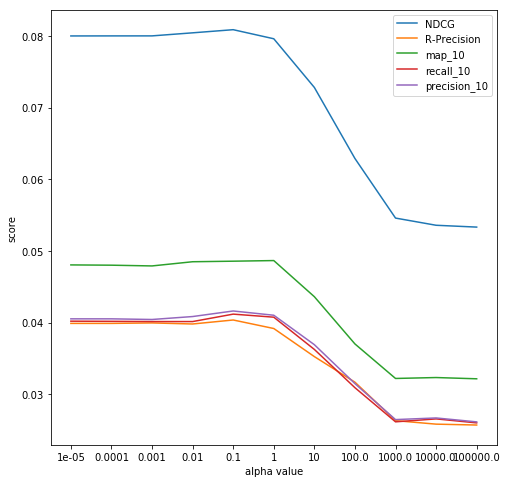

In [72]:
plt.figure(figsize=(8,8))

plt.plot(np.arange(len(alpha_list)), ndcgs)
plt.plot(np.arange(len(alpha_list)), r_precisions)
plt.plot(np.arange(len(alpha_list)), map_10)
plt.plot(np.arange(len(alpha_list)), recall_10)
plt.plot(np.arange(len(alpha_list)), precision_10)

plt.xticks(np.arange(len(alpha_list)), alpha_list)
plt.xlabel('alpha value')
plt.ylabel('score')
plt.legend(['NDCG','R-Precision','map_10','recall_10','precision_10'])
plt.show()
# plt.savefig('../figs/Tuning_latent_similarity_space_LR')

### Best Alpha on validation set = 0.1

In [16]:
clf = Ridge(alpha=0.1).fit(X, y)
lr_similarity = clf.predict(np.array(X))
lr_prediction_score = predict(rtrain, 100, lr_similarity, item_similarity_en= False)
lr_predict = prediction(lr_prediction_score, 50, rtrain)
lr_res = evaluate(lr_predict, rtest)

100%|████████████████████████████████████████████████████████████████████████████| 2343/2343 [00:00<00:00, 4075.11it/s]


In [23]:
# Result on test data
lr_res

{'MAP@10': (0.0579191932364, 0.004337173760974245),
 'MAP@15': (0.05410621479539782, 0.0036420905948940153),
 'MAP@20': (0.0514113544178991, 0.00321063889760705),
 'MAP@5': (0.06349003499163244, 0.005785447754232044),
 'MAP@50': (0.04161249065006333, 0.0021296299920805146),
 'NDCG': (0.08514745492045937, 0.0037227182371916663),
 'Precision@10': (0.04906435417617526, 0.0030992493571670326),
 'Precision@15': (0.04533698463410924, 0.002564070020831653),
 'Precision@20': (0.04210406207211319, 0.002221280781856864),
 'Precision@5': (0.05942492012779552, 0.004510206593046768),
 'Precision@50': (0.030789593792788686, 0.0013693555346728124),
 'R-Precision': (0.04498034624026185, 0.002658267116070035),
 'Recall@10': (0.03907562491767253, 0.0026192096631670594),
 'Recall@15': (0.05420595429830032, 0.003173562295251404),
 'Recall@20': (0.06650439279850905, 0.003556459694516587),
 'Recall@5': (0.024423385789734176, 0.002051772794243629),
 'Recall@50': (0.11966359399827448, 0.0047284204524481906)}

# Popularity Baselines

## 1. Recommend most-reviewed restaurants to customers

In [157]:
def get_most_reviewed_item(df, item_col = 'ItemIndex', topk = 50):
    item_index = df[item_col]
    item_frequency = item_index.value_counts()
    return item_frequency.index[:20]

In [87]:
get_most_reviewed_item(df_train, target_col = 'ItemIndex', topk = 50)

Int64Index([6454, 4443, 5410, 2804, 1652, 3347, 6776,   75, 1406, 7100, 4908,
            5010, 5315, 5659, 2847, 7427, 1522, 3149, 5577,  201],
           dtype='int64')

## 2. Recommend highest-average-ratings restaurants to customers 

In [103]:
means = [item_idx.loc[item_idx['ItemIndex'] == i]['rating'].mean() for i in range(rtrain.shape[1])]

In [108]:
means_allvalid = np.nan_to_num(means, nan=0)

In [116]:
def get_highest_avg_rating_item(df, item_size = 7456, item_col = 'ItemIndex', rating_col= 'rating', topk = 50):
    item_idx = df[[item_col, rating_col]]
    avg_ratings = [item_idx.loc[item_idx[item_col] == i][rating_col].mean() for i in range(item_size)]
    avg_ratings = np.nan_to_num(avg_ratings, nan=0) # Setting nan to 0 rating
    topk_index = np.argsort(avg_ratings)[::-1][:topk]
    return topk_index

def construct_avg_rating(df, item_size = 7456, item_col = 'ItemIndex', rating_col= 'rating'):
    item_idx = df[[item_col, rating_col]]
    avg_ratings = [item_idx.loc[item_idx[item_col] == i][rating_col].mean() for i in range(item_size)]
    avg_ratings = np.nan_to_num(avg_ratings, nan=0) # Setting nan to 0 rating
    return avg_ratings

def get_highest_avg_rating_item2(avg_ratings, topk = 50):
    """
    Quicker version for get_highest_avg_rating_item(), but needed to construct avg_ratings array first
    """
    return np.argsort(avg_ratings)[::-1][:topk]

In [117]:
get_highest_avg_rating_item(df_train,item_col = 'ItemIndex', rating_col= 'rating', topk = 50)

array([3727, 6753, 3701, 3704, 3708, 6768, 3714, 3724, 3736, 3746, 3749,
       3763, 3766, 3769, 3931, 6751, 6750, 3773, 3781, 3784, 3798, 3809,
       3853, 3884, 3911, 3919, 6775, 3673, 6778, 3641, 3336, 3339, 3345,
       6817, 3381, 3394, 3398, 3404, 3433, 3435, 3457, 3467, 3469, 3479,
       3500, 6797, 3542, 3547, 3573, 3581], dtype=int64)

## 3. Recommend restaurants with most 4/5-ratings to customers

In [128]:
threshold = 3
df_train['pos_rating'] = (df_train['rating'] > threshold)*1
# df[BINARY_RATING] = (df[RATING] > threshold)*1

In [135]:
df_train.loc[df_train['ItemIndex'] == 0]['pos_rating'].sum()

5

In [131]:
rtrain

<2343x7456 sparse matrix of type '<class 'numpy.float32'>'
	with 95153 stored elements in Compressed Sparse Row format>

In [132]:
def get_most_pos_rating_item(df, item_size = 7456, threshold = 3,
                             item_col = 'ItemIndex', BINARY_RATING= 'pos_rating',RATING = 'rating', topk = 50):
    """
    Similar to highest average rating, but with sum of binary ratings
    """
    df[BINARY_RATING] = (df[RATING] > threshold)*1 # get implicit rating (positive threshold = 3 by default)
    item_idx = df[[item_col, BINARY_RATING]]
    sum_ratings = [item_idx.loc[item_idx[item_col] == i][BINARY_RATING].sum() for i in range(item_size)]
    sum_ratings = np.nan_to_num(sum_ratings, nan=0) # Setting nan to 0 rating
    topk_index = np.argsort(sum_ratings)[::-1][:topk]
    return topk_index

In [134]:
get_most_pos_rating_item(df_train, item_size = 7456, threshold = 3,
                             item_col = 'ItemIndex', BINARY_RATING= 'pos_rating',RATING = 'rating', topk = 50)

array([6454, 5410, 4443, 2804, 6776, 1652, 6222, 1406, 7100,  201, 4908,
       5315, 5010, 5659,   75, 5286, 5081, 5626, 5363, 1522, 4141, 3428,
       7313, 3377, 2446, 4397, 7163, 3347, 2729, 5972, 1548, 6739, 4762,
       2514, 3997,  754,  325, 3211, 5577, 1445, 2188, 6732, 3739, 5852,
       2895,  419, 1985, 1113, 4037, 2942], dtype=int64)

## 4. Other baselines

## Baseline Prediction Res

In [164]:
def baseline_recommendation(df, user_size = 2343, item_size = 7456, 
                            item_col = 'ItemIndex', BINARY_RATING= 'pos_rating',RATING = 'rating', topk = 50, method = 1):
    if method == 1:
        
        # 1. Recommend most-reviewed restaurants to customers
        topk_item = get_most_reviewed_item(df_train, item_col = item_col, topk = topk)
    elif method == 2:
        # 2. Recommend highest-average-ratings restaurants to customers
        topk_item = get_highest_avg_rating_item(df_train, item_col = item_col, rating_col= RATING, topk = topk)
    elif method == 3:
        # 3. Recommend restaurants with most 4/5-ratings to customers
        topk_item = get_most_pos_rating_item(df_train, item_size = item_size, threshold = 3,
                                 item_col = item_col, BINARY_RATING= BINARY_RATING, RATING = RATING, topk = topk)
    baseline_prediction = [np.array(topk_item)]*user_size
    return np.array(baseline_prediction)

In [159]:
base_predict = baseline_recommendation(df_train, user_size = 2343, item_size = 7456, 
                            item_col = 'ItemIndex', BINARY_RATING= 'pos_rating',RATING = 'rating', topk = 50, method = 1)

In [161]:
base_res = evaluate(base_predict, rvalid)

100%|████████████████████████████████████████████████████████████████████████████| 2343/2343 [00:00<00:00, 4180.00it/s]


In [162]:
base_res

{'MAP@10': (0.02756279295530779, 0.0030674003503804296),
 'MAP@15': (0.025664745856439148, 0.002495221336583842),
 'MAP@20': (0.0245251386356516, 0.002154826475118933),
 'MAP@5': (0.03146812718697702, 0.004299791684373221),
 'MAP@50': (0.0245251386356516, 0.002154826475118933),
 'NDCG': (0.035676821097590614, 0.0028569302171470522),
 'Precision@10': (0.022866271109082615, 0.001988596051332705),
 'Precision@15': (0.021481819564886658, 0.0016070534268667908),
 'Precision@20': (0.02083523505248745, 0.0014204913842516612),
 'Precision@5': (0.024372432679141947, 0.0029077654080710857),
 'Precision@50': (0.02083523505248745, 0.0014204913842516612),
 'R-Precision': (0.02208079679050068, 0.002045209143131415),
 'Recall@10': (0.02382092703618299, 0.002287648852888764),
 'Recall@15': (0.033385924988189306, 0.0027159580476557293),
 'Recall@20': (0.04260836046012948, 0.0030774531232506393),
 'Recall@5': (0.01306075448751601, 0.001733854536671442),
 'Recall@50': (0.04260836046012948, 0.003077453123

In [165]:
base_predict = baseline_recommendation(df_train, user_size = 2343, item_size = 7456, 
                            item_col = 'ItemIndex', BINARY_RATING= 'pos_rating',RATING = 'rating', topk = 50, method = 2)

In [166]:
base_res = evaluate(base_predict, rvalid)

100%|████████████████████████████████████████████████████████████████████████████| 2343/2343 [00:00<00:00, 4107.24it/s]


In [167]:
base_res

{'MAP@10': (0.00023925438119869888, 0.00018890762255986796),
 'MAP@15': (0.0002793810142052953, 0.00018504787859034537),
 'MAP@20': (0.0002860790734558032, 0.00017480285580780816),
 'MAP@5': (0.00013083827780313402, 0.00015999478795695156),
 'MAP@50': (0.00027032663727369246, 0.00012440828866581207),
 'NDCG': (0.0006786256462460687, 0.0002741411553596563),
 'Precision@10': (0.0004107713372889092, 0.00025898593396981765),
 'Precision@15': (0.0003347025711242964, 0.000190792315976979),
 'Precision@20': (0.00027384755819260615, 0.00014942277305503114),
 'Precision@5': (0.00027384755819260615, 0.00029946207625880164),
 'Precision@50': (0.0002464628023733455, 8.934454787826891e-05),
 'R-Precision': (0.00029551214819409697, 0.0001764347223105854),
 'Recall@10': (0.00039290353644529823, 0.0002793898005101686),
 'Recall@15': (0.0004980167406000359, 0.00032943253005846956),
 'Recall@20': (0.0005170339321411891, 0.0003313507790775532),
 'Recall@5': (0.00011878430408781848, 0.0001307098316334704)

In [168]:
base_predict = baseline_recommendation(df_train, user_size = 2343, item_size = 7456, 
                            item_col = 'ItemIndex', BINARY_RATING= 'pos_rating',RATING = 'rating', topk = 50, method = 3)

In [169]:
base_res = evaluate(base_predict, rvalid)

100%|████████████████████████████████████████████████████████████████████████████| 2343/2343 [00:00<00:00, 4143.33it/s]


In [170]:
base_res

{'MAP@10': (0.026848815138408928, 0.0030582277610226734),
 'MAP@15': (0.02479511706576974, 0.0024835827470534857),
 'MAP@20': (0.023597298766080462, 0.0021372343536750077),
 'MAP@5': (0.03148638369085653, 0.004293697270112032),
 'MAP@50': (0.01935310615849926, 0.0013169468896284768),
 'NDCG': (0.048252012535976815, 0.0029840713542375464),
 'Precision@10': (0.021040620721131907, 0.0019459208520586748),
 'Precision@15': (0.021390537045489124, 0.0016038726862727547),
 'Precision@20': (0.0193518941122775, 0.0013427970336753483),
 'Precision@5': (0.02628936558649019, 0.0030172956768867967),
 'Precision@50': (0.014824281150159746, 0.0007996623320726392),
 'R-Precision': (0.02258659626024878, 0.002087125571553334),
 'Recall@10': (0.02174962011198104, 0.002183283532423727),
 'Recall@15': (0.03324965244811066, 0.002700859989671627),
 'Recall@20': (0.03956607739668501, 0.0029368771587676987),
 'Recall@5': (0.014723698025483165, 0.0018582930154224643),
 'Recall@50': (0.07409566385413648, 0.003957

# One-hot encoding of critiques

Use one-hot encoding of critiques to project into user-similarity space

In [18]:
U_K

<2343x235 sparse matrix of type '<class 'numpy.int32'>'
	with 242115 stored elements in Compressed Sparse Row format>

In [19]:
def get_critiqued_UK(user_keyphrase_frequency,user_index,critiqued_keyphrase):
    """
    user_keyphrase_frequency is the U_K matrix (csr sparse matrix)
    return the one-hot encoding of the critique
    """
    U_K_cp = user_keyphrase_frequency.copy()
    U_K_cp[user_index] = 0
    U_K_cp[user_index,critiqued_keyphrase] = 1
    return U_K_cp

def project_one_hot_encoding(reg, user_keyphrase_frequency,user_index = 0,critiqued_keyphrase = 0, normalize_en = True):
    """
    Return the projection on user_sim space from one-hot encoding of critiqued keyphrase
    The res[user_index] should be target embedding row
    """
    critiqued_matrix = get_critiqued_UK(user_keyphrase_frequency, user_index, critiqued_keyphrase)
    res = reg.predict(critiqued_matrix)
    if normalize_en:
        res = normalize((res))
    return res

In [22]:
# test
critiqued_matrix = project_one_hot_encoding(clf, U_K, user_index = 0,critiqued_keyphrase = 0,normalize_en = True)

D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [23]:
critiqued_matrix[1]

array([0.00796337, 0.10243862, 0.02584304, ..., 0.        , 0.00039013,
       0.00089107])

# Single Step Critiquing with Averaging 

In [183]:
def get_initial_predictions(X = normalize(U_K.todense()), y = normalize(train(rtrain)),
                            matrix_Train = rtrain, k = 100):
    clf = Ridge(alpha=0.1).fit(X, y)
    similarity = normalize(train(matrix_Train))
    user_item_prediction_score = predict(matrix_Train, k, similarity, item_similarity_en= False)
    return user_item_prediction_score, clf


In [1]:
def get_valid_keyphrases(keyphrase_freq,item = None,threshold=50,mutiple_keyphrases_en = False, top_items = None):
    """
    Wrapper function to get either top 1 or top n keyphrases
    """
    if mutiple_keyphrases_en:
        top_keyphrases = []
        for item in top_items:
            top_keyphrases.extend(get_valid_keyphrases_for_one_item(keyphrase_freq,item,threshold=threshold))
        return np.ravel(list(set(top_keyphrases))) # remove duplicate and reformat to np array
    else:
        return get_valid_keyphrases_for_one_item(keyphrase_freq,item,threshold=threshold)

def get_valid_keyphrases_for_one_item(keyphrase_freq,item,threshold=50):
    """
    Get keyphrases of item that make sense
    E.g. if the item has fewer than threshold=50 keyphrases, get all of them
    otherwise get top 50 keyphrases
    """
    keyphrase_length = len(keyphrase_freq[item].nonzero()[1])
    if keyphrase_length<threshold:
        return keyphrase_freq[item].nonzero()[1]
    else:
        keyphrases = np.ravel(keyphrase_freq[top_recommendations[0]].todense())
        top_keyphrases = np.argsort(keyphrases)[::-1][:threshold]
        return top_keyphrases

##### How Many Keyphrases does each item have

In [74]:
max_length = 0
sum_length = 0
for i in range(I_K.shape[0]):
    length = len(keyphrase_freq[i].nonzero()[1])
    sum_length += length
    if length > max_length:
        max_length = length
        index = i
print ("The item has a maximum keyphrases of: ",max_length, ".At Index: ",index)
print ("Average keyphrases length of an item is: ", sum_length/I_K.shape[0])

The item has a maximum keyphrases of:  178 .At Index:  7100
Average keyphrases length of an item is:  36.408932403433475


## Crituqing Pipline

In [111]:
import copy

In [187]:
user = 2
target_rank = 200 # looking at Hit Rate
max_iteration_threshold = 1 # Looking at single step ciritiquing first
k = 50 # HR@k 

matrix_Train = rtrain
matrix_Test = rtest
keyphrase_freq = I_K
keyphrase_popularity = None # TODO 
num_items = rtrain.shape[1]

#Linear Regression for embedding
# X = normalize(U_K.todense()) 
# y = normalize(train(rtrain))
# clf = Ridge(alpha=0.1).fit(X, y)
# lr_similarity = clf.predict(np.array(X))

# Get wanted items 
candidate_items = matrix_Test[user].nonzero()[1]
train_items = matrix_Train[user].nonzero()[1]
wanted_items = np.setdiff1d(candidate_items, train_items)

print ('wanted_items are: ',wanted_items)

wanted_items are:  [  75  637  648  712 1082 1254 1522 3838 4130 4397 4443 5618 5965]


In [185]:
# Get initial prediction 
prediction_score,clf = get_initial_predictions(X = normalize(U_K.todense()), y = normalize(train(rtrain)),
                            matrix_Train = rtrain, k = 100)

100%|█████████████████████████████████████████████████████████████████████████████| 2343/2343 [00:07<00:00, 299.31it/s]


In [186]:
# Get initial top recommended item(s)
top_recommendations = np.argsort(prediction_score[user])[::-1]
print ("Initial top recommendation ",top_recommendations[0])

Initial top recommendation  6454


In [209]:
for item in wanted_items:
    print ('target_item: ', item)
    
    # Get rank of target item in pre-critiquing
    initial_topk_prediction = np.argsort(prediction_score[user])[::-1][:k]
    print ('target_item in initial top k prediction? ', item in initial_topk_prediction)
    initial_rank = np.where(item == np.argsort(prediction_score[user])[::-1])[0][0]
    print ('target_item initial rank', int(initial_rank))
    
    # Get the target item's existing keyphrases
    item_keyphrases = keyphrase_freq[item].nonzero()[1]
    print ('num_existing_keyphrases ',len(item_keyphrases))
    
    # Get keyphrases that is in the top recommended items but not in the target item (we can critique)
    top_item = top_recommendations[0] 
    top_recommend_keyphrases = get_valid_keyphrases(keyphrase_freq,item = top_item,threshold=keyphrase_length_threshold,
                                                   mutiple_keyphrases_en = False, top_items = None)
    print ('num_top_recommended_keyphrases ',len(top_recommend_keyphrases))
    wanted_keyphrases = np.setdiff1d(item_keyphrases,top_recommend_keyphrases)
    print ('wanted_keyphrases ',wanted_keyphrases)
    
    if len(wanted_keyphrases) == 0:
        print ("wanted_keyphrases is empty")
        break
    
    break #looking at one item first

target_item:  75
target_item in initial top k prediction?  False
target_item initial rank 86
num_existing_keyphrases  129
num_top_recommended_keyphrases  150
wanted_keyphrases  [ 19  60  82  83 115 129 137 156 157 158 191]


In [242]:
query = []
affected_items = np.array([])
modified_matrix = normalize(train(matrix_Train)) # initialize user embedding (user similarity embedding)

for iteration in range(max_iteration_threshold):
    print ('cur_iter ', iteration)
    
    # Randomly critique one keyphrase
    critiqued_keyphrase = np.random.choice(wanted_keyphrases, size=1, replace=False)[0]
    # Always critique the most popular keyphrase
    # critiqued_keyphrase = wanted_keyphrases[np.argmax(keyphrase_popularity[wanted_keyphrases])]
    
    print ('critiqued_keyphrase ,',critiqued_keyphrase, keyphrases[critiqued_keyphrase])
    query.append(critiqued_keyphrase)
    
    # Get affected items (items have critiqued keyphrase)
    current_affected_items = keyphrase_freq[:, critiqued_keyphrase].nonzero()[0]
    affected_items = np.unique(np.concatenate((affected_items, current_affected_items))).astype(int) 
    unaffected_items = np.setdiff1d(range(num_items), affected_items)
    
#     print ('affected items ,',current_affected_items)
    print ('Target item in affected item? ', critiqued_keyphrase in affected_items)
    
    # Critiquing Embedding
    
    ## TODO: test this function works
    critiqued_matrix = project_one_hot_encoding(clf, 
                                                U_K,
                                                user_index = user,
                                                critiqued_keyphrase = critiqued_keyphrase, 
                                                normalize_en = True)
    
    modified_matrix = modified_matrix + critiqued_matrix # averaging user-item embedding and critiquing embeeding
    
    
    # Get new predictions from modified embedding
    
    prediction_scores_u = predict(rtrain, 100, modified_matrix, item_similarity_en= False)
    # Evaluate post critique target item rank and HR@k
    post_critique_topk_prediction = np.argsort(prediction_scores_u[user])[::-1][:k]
    print ("target_item in post-critique top k prediction? ", item in post_critique_topk_prediction)
    post_critique_rank = np.where(item == np.argsort(prediction_scores_u[user])[::-1])[0][0]
    print ('target_item post-critique rank', int(post_critique_rank))
    

cur_iter  0
critiqued_keyphrase , 82 booth
Target item in affected item?  False


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
100%|█████████████████████████████████████████████████████████████████████████████| 2343/2343 [00:13<00:00, 175.91it/s]


target_item in post-critique top k prediction?  True
target_item post-critique rank 43


In [390]:
# columns = ['user_id', 'item_id', 'target_rank', 'iteration', 'critiqued_keyphrase', 'item_rank', 'item_score', 'num_existing_keyphrases', 'result', 'lambda']
columns = ['user_id', 'target_item', 'item_name', 'pre_rank', 'top_prediction_item_name','critiqued_keyphrase', 'keyphrase_name', 'post_rank', 'num_existing_keyphrases']

df = pd.DataFrame(columns=columns)
row = {}
# row['result'] = 'fail'
# df = df.append(row, ignore_index=True)

In [499]:
def predict_vector(user_index, matrix_train, k, similarity):
    """
    get only user_index row
    """
    vector_u = similarity[user_index]
    
    # Get closest K neighbors excluding user u self
    similar_users = vector_u.argsort()[::-1][1:k+1]
    # Get neighbors similarity weights and ratings
    similar_users_weights = similarity[user_index][similar_users]
    similar_users_ratings = matrix_train[similar_users].toarray()
    prediction_scores_u = similar_users_ratings * similar_users_weights[:, np.newaxis]
    
    return np.sum(prediction_scores_u, axis=0)


def get_initial_prediction(user,X = normalize(U_K.todense()), y = normalize(train(rtrain)),
                            matrix_Train = rtrain, k = 100):
    clf = Ridge(alpha=0.1).fit(X, y)
    similarity = normalize(train(matrix_Train))
    user_item_prediction_score = predict_vector(user, matrix_Train, k, similarity)
    return user_item_prediction_score, clf


def single_step_critiquing(user = 2, 
                           keyphrase_length_threshold = 150, 
                           max_iteration_threshold = 1,
                           k = 50,
                           df = df,
                           row = row,
                           business_df = business_df,
                           ItemIndex = ItemIndex, 
                           keyphrases = keyphrases):
    """
    k: HR@k 
    """
    
    row['user_id'] = user
    print ('User ID ', user)
    # Set up 
    matrix_Train = rtrain
    matrix_Test = rtest
    keyphrase_freq = I_K
    keyphrase_popularity = None # TODO 
    num_items = rtrain.shape[1]

    # Get wanted items 
    candidate_items = matrix_Test[user].nonzero()[1]
    train_items = matrix_Train[user].nonzero()[1]
    wanted_items = np.setdiff1d(candidate_items, train_items)
    print ('wanted_items are: ',wanted_items)
    
    # Get initial prediction 
    prediction_score,clf = get_initial_prediction(user, X = normalize(U_K.todense()), y = normalize(train(rtrain)),
                            matrix_Train = rtrain, k = 100)
    # Get initial top recommended item(s)
    top_recommendations = np.argsort(prediction_score)[::-1]
    print ("Initial top recommendation ",top_recommendations[0])
    try:
        row['top_prediction_item_name'] = get_restaurant_name(df_train, business_df, top_recommendations[0])
    except:
        pass
    
    #####################################
    # For each item, do the critiquing
    
    #limit the item to only 10
    num_target_item = 0
    for item in wanted_items:
        
        print ('target_item: ', item)
        row['target_item'] = item
        try:
            row['item_name'] = get_restaurant_name(df_train, business_df, item)
        except:
            pass 
        # Get rank of target item in pre-critiquing
        initial_rank = np.where(item == np.argsort(prediction_score)[::-1])[0][0]
        print ('target_item initial rank', int(initial_rank))
        row['pre_rank'] = int(initial_rank)

        # Get the target item's existing keyphrases
        item_keyphrases = keyphrase_freq[item].nonzero()[1]
        print ('num_existing_keyphrases ',len(item_keyphrases))
        print ('exisiting_keyphrases', item_keyphrases)
        
        # Get top recommended item's keyphrases
        top_item = top_recommendations[0] 
        top_recommend_keyphrases = get_valid_keyphrases(keyphrase_freq,item = top_item,threshold=keyphrase_length_threshold,
                                                       mutiple_keyphrases_en = False, top_items = None)
        print ('num_top_recommended_keyphrases ',len(top_recommend_keyphrases))
        
        # Get keyphrases that is not in the top recommended items but in the target item (we can select)
        wanted_keyphrases = np.setdiff1d(item_keyphrases,top_recommend_keyphrases)
        print ('wanted_keyphrases ',wanted_keyphrases)

        if len(wanted_keyphrases) == 0:
            print ("wanted_keyphrases is empty")
            break
        row['num_existing_keyphrases'] = len(wanted_keyphrases)
        
#         break #looking at one item first
        
        query = []
        affected_items = np.array([])
        modified_matrix = normalize(train(matrix_Train)) # initialize user embedding (user similarity embedding)
        
        #############################################
        # Critiquing iteration
        for iteration in range(max_iteration_threshold):
            print ('cur_iter ', iteration)
            
            # Randomly critique one keyphrase
            critiqued_keyphrase = np.random.choice(wanted_keyphrases, size=1, replace=False)[0]
            # Always critique the most popular keyphrase
            # critiqued_keyphrase = wanted_keyphrases[np.argmax(keyphrase_popularity[wanted_keyphrases])]

            
            print ('critiqued_keyphrase ,',critiqued_keyphrase, keyphrases[critiqued_keyphrase])
            row['critiqued_keyphrase'] = critiqued_keyphrase
            row['keyphrase_name'] = keyphrases[critiqued_keyphrase]
            query.append(critiqued_keyphrase)
            
            # Do not critique this keyphrase next time
            wanted_keyphrases = np.delete(wanted_keyphrases, np.where(critiqued_keyphrase == wanted_keyphrases))
            if len(wanted_keyphrases) == 0: break
            
            # Get affected items (items have critiqued keyphrase)
            current_affected_items = keyphrase_freq[:, critiqued_keyphrase].nonzero()[0]
            affected_items = np.unique(np.concatenate((affected_items, current_affected_items))).astype(int) 
            unaffected_items = np.setdiff1d(range(num_items), affected_items)

        #     print ('affected items ,',current_affected_items)
#             print ('Target item in affected item? ', critiqued_keyphrase in affected_items)

            # Critiquing Embedding

            ## TODO: test this function works
            critiqued_matrix_onehot = get_critiqued_UK(U_K,user,critiqued_keyphrase)
            critiqued_matrix = clf.predict(critiqued_matrix_onehot)
            critiqued_matrix = normalize(critiqued_matrix)
            
#             critiqued_matrix = project_one_hot_encoding(clf, 
#                                                         U_K,
#                                                         user_index = user,
#                                                         critiqued_keyphrase = critiqued_keyphrase, 
#                                                         normalize_en = True)

#             modified_matrix = modified_matrix + critiqued_matrix # averaging user-item embedding and critiquing embeeding
            
            # Warning!!! The following is used only for testing single step critiquing, 
            # for full average critiquing, use the above commented line 
            modified_matrix = normalize(train(matrix_Train)) + critiqued_matrix 
            modified_matrix = normalize(modified_matrix)
            
            # Get new predictions from modified embedding
            prediction_scores_u = predict_vector(user, matrix_Train, 100, modified_matrix)
            
            # Evaluate post critique target item rank and HR@k
#             post_critique_topk_prediction = np.argsort(prediction_scores_u)[::-1][:k]
#             print ("target_item in post-critique top k prediction? ", item in post_critique_topk_prediction)
            post_critique_rank = np.where(item == np.argsort(prediction_scores_u)[::-1])[0][0]
            print ('target_item post-critique rank', int(post_critique_rank))
            row['post_rank'] = int(post_critique_rank)
            
            
#             if avg_post_rank != None:
#                 row['avg_post_rank'] = avg_post_rank
            
            df = df.append(row, ignore_index=True)
            
#         break # test for only one item at a time 
        # break after got 10 target items 
        num_target_item += 1
        
        if num_target_item >10:
            break
            
    return df

In [500]:
def get_critiqued_UK(user_keyphrase_frequency,user_index,critiqued_keyphrase):
    """
    user_keyphrase_frequency is the U_K matrix (csr sparse matrix)
    return the one-hot encoding of the critique
    """
    U_K_cp = user_keyphrase_frequency.copy()
    U_K_cp[user_index] = 0
    U_K_cp = U_K_cp.todense()
    U_K_cp[user_index,critiqued_keyphrase] = 1
    return U_K_cp

def project_one_hot_encoding(reg, user_keyphrase_frequency,user_index = 0,critiqued_keyphrase = 0, normalize_en = True):
    """
    Return the projection on user_sim space from one-hot encoding of critiqued keyphrase
    The res[user_index] should be target embedding row
    """
    critiqued_matrix = get_critiqued_UK(user_keyphrase_frequency, user_index, critiqued_keyphrase)
#     print (critiqued_matrix)
    res = reg.predict(critiqued_matrix)
    if normalize_en:
        res = normalize((res))
    return res

In [509]:
columns = ['user_id', 'target_item', 'item_name', 'pre_rank', 'top_prediction_item_name','critiqued_keyphrase', 'keyphrase_name', 'post_rank', 'num_existing_keyphrases']

df = pd.DataFrame(columns=columns)
row = {}

In [ ]:
df = single_step_critiquing(user = 2, 
                           keyphrase_length_threshold = 230, 
                           max_iteration_threshold = 5,
                           k = 50,
                           df = df,
                           row = row,
                           business_df = business_df,
                           ItemIndex = ItemIndex, 
                           keyphrases = keyphrases)

In [506]:
df

,user_id,target_item,item_name,pre_rank,top_prediction_item_name,critiqued_keyphrase,keyphrase_name,post_rank,num_existing_keyphrases
0,2,75,b'Salad King Restaurant',86,b'Pai Northern Thai Kitchen',158,bright,8,10
1,2,75,b'Salad King Restaurant',86,b'Pai Northern Thai Kitchen',19,indian,9,10
2,2,75,b'Salad King Restaurant',86,b'Pai Northern Thai Kitchen',156,soggy,76,10
3,2,75,b'Salad King Restaurant',86,b'Pai Northern Thai Kitchen',115,lobster,311,10
4,2,75,b'Salad King Restaurant',86,b'Pai Northern Thai Kitchen',191,frozen,260,10
5,2,637,b'Daldongnae',16,b'Pai Northern Thai Kitchen',146,plaza,49,13
6,2,637,b'Daldongnae',16,b'Pai Northern Thai Kitchen',27,bbq,1,13
7,2,637,b'Daldongnae',16,b'Pai Northern Thai Kitchen',189,fluffy,32,13
8,2,637,b'Daldongnae',16,b'Pai Northern Thai Kitchen',82,booth,357,13
9,2,637,b'Daldongnae',16,b'Pai Northern Thai Kitchen',123,steak,227,13


In [507]:
df.to_csv("Single_Step_Critiquing_With_AVG_example_user2.csv")

### Run for More users

In [ ]:
columns = ['user_id', 'target_item', 'item_name', 'pre_rank', 'top_prediction_item_name','critiqued_keyphrase', 'keyphrase_name', 'post_rank', 'num_existing_keyphrases']

df = pd.DataFrame(columns=columns)
row = {}

for user in range(300,400):
    df = single_step_critiquing(user = user, 
                           keyphrase_length_threshold = 100, 
                           max_iteration_threshold = 5,
                           k = 50,
                           df = df,
                           row = row,
                           business_df = business_df,
                           ItemIndex = ItemIndex, 
                           keyphrases = keyphrases)

In [ ]:
df

In [512]:
df.to_csv("Single_Step_Critiquing_With_AVG_100user_with_normalization.csv")

##  Get the HR@50

In [513]:
def hr_at_k(df, k):
    """
    Given the above dataframe, calculate the avg pre and post hit rate at k 
    """
    pre_hit = np.where(df['pre_rank']<k)[0]
    post_hit = np.where(df['post_rank']<k)[0]
#     print (len(np.ravel(pre_hit)))
#     print (len(np.ravel(pre_hit)))
    pre_hr = len(pre_hit)/len(df)
    post_hr = len(post_hit)/len(df)
    return pre_hr, post_hr

## Plot the PRE POST HR 

In [519]:
pre_hr_list = []
post_hr_list = []
for k in range(1,200):
    pre_hr,post_hr = hr_at_k(df, k)
    pre_hr_list.append(pre_hr)
    post_hr_list.append(post_hr)

In [520]:
plt.figure(figsize=(8,8))

plt.plot(np.arange(len(pre_hr_list)), pre_hr_list)
plt.plot(np.arange(len(pre_hr_list)), post_hr_list)

# plt.xticks(np.arange(len(k_list)), k_list)
plt.xlabel('k')
plt.ylabel('HR@K')
plt.legend(['Pre-Critiquing hit rate','Post-Critiquing hit rate'])
# plt.show()
plt.savefig('../figs/HitRate200_pre_post_critiquing')

## Example of single step critiquing

In [232]:
def get_business_df(path = "../../data/yelp/business.json" ):
    with open(path,encoding="utf8") as json_file:
        data = json_file.readlines()
        data = list(map(json.loads, data))
    df = pd.DataFrame(data)
    
    return df

def get_restaurant_info(business_df, business_id, name = True, review_count = True, stars = True ):
    output_list = {}
    row_idx = int(business_df.index[business_df['business_id'] == business_id].tolist()[0])
    if name == True:
        output_list['name'] = business_df['name'][row_idx].encode('utf-8').strip()
    if review_count == True:
        output_list['review_count'] = business_df['review_count'][row_idx]
    if stars == True:
        output_list['stars'] = business_df['stars'][row_idx] 
    return output_list

def get_businessid_from_Itemindex(ItemIndex_list, itemindex):
    return ItemIndex_list['business_id'].tolist()[itemindex]

# def get_restaurant_name(business_df, ItemIndex, item):
#     """
#     directly get restaurant name from item index
#     """
#     return get_restaurant_info(business_df, get_businessid_from_Itemindex(ItemIndex, item))['name']

In [217]:
business_df = get_business_df()

In [426]:
def get_restaurant_name(df_train, business_df, ItemIndex):
    rows = np.where(df_train['ItemIndex'] == ItemIndex)
    if len(rows)!= 0:
        business_id = df_train.loc[rows[0][0]]['business_id']
        item_info = get_restaurant_info(business_df, business_id)
        return item_info['name']
    return "NOT_FOUND"

In [425]:
get_restaurant_name(df_train, business_df, 3838)

b'Lucullus Bakers & Roasters'

# Embedding of original U_U + critique projection

In [165]:
# initialize the matrix
modified_matrix = normalize(train(rtrain)).copy()

In [166]:
modified_matrix[0]

array([0.4867929 , 0.01587667, 0.01536822, ..., 0.        , 0.        ,
       0.        ], dtype=float32)

# Learn the lambdas

In [167]:
modified_matrix

array([[0.4867929 , 0.01587667, 0.01536822, ..., 0.        , 0.        ,
        0.        ],
       [0.01717785, 0.5266886 , 0.00329018, ..., 0.        , 0.01379578,
        0.        ],
       [0.01747107, 0.00345705, 0.55340123, ..., 0.        , 0.        ,
        0.0229555 ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.01634563, 0.        , ..., 0.        , 0.6240353 ,
        0.        ],
       [0.        , 0.        , 0.02697603, ..., 0.        , 0.        ,
        0.6503266 ]], dtype=float32)

In [168]:
critiqued_matrix

array([[-0.00612141, -0.02221741, -0.00579472, ...,  0.        ,
         0.03756859, -0.0309494 ],
       [ 0.00503134,  0.1046469 ,  0.02630396, ...,  0.        ,
         0.00029115,  0.00124497],
       [ 0.01630788,  0.02821016,  0.09550076, ...,  0.        ,
         0.01960971,  0.02490069],
       ...,
       [ 0.00338559, -0.04381626, -0.01855125, ...,  0.        ,
        -0.01606787,  0.03146326],
       [ 0.01187455,  0.01655502,  0.02848183, ...,  0.        ,
         0.15997426,  0.01094426],
       [ 0.0025182 , -0.00189156,  0.03735052, ...,  0.        ,
         0.03354831,  0.1618768 ]])

In [170]:
# AVERAGE 

# Combine critiqued matrix with modified directly (asumming only one critique)
modified_matrix = modified_matrix + critiqued_matrix

In [171]:
modified_matrix[0]

array([ 0.48067148, -0.00634074,  0.00957349, ...,  0.        ,
        0.03756859, -0.0309494 ])

### Constructing the w*p matrix

In [183]:
W.reshape(2343,1)

array([[ 0.48067148],
       [-0.00634074],
       [ 0.00957349],
       ...,
       [ 0.        ],
       [ 0.03756859],
       [-0.0309494 ]])

In [186]:
# l = lambda, the weights we want to learn
W = modified_matrix[0]
P = rtrain[:,0]

In [191]:
train_row = W*np.ravel(P.todense())

In [193]:
train_row.shape

(2343,)

## Define rating targets

In [ ]:
# To define the rating targets, simply modify final prediction of U-I matrix's user_index row,
# Make the target critiqued item's predicted rating to be 1 (out of 5)

In [202]:
critiqued_keyphrase = 0
user_index = 0
affected_items = I_K[:, critiqued_keyphrase].nonzero()[user_index]

In [206]:
affected_items

array([   2,    6,   13, ..., 7434, 7439, 7441])

In [204]:
target_rating = rtrain[user_index]
print (target_rating)

  (0, 309)	5.0
  (0, 539)	4.0
  (0, 585)	3.0
  (0, 719)	4.0
  (0, 823)	4.0
  (0, 831)	5.0
  (0, 1438)	4.0
  (0, 1650)	4.0
  (0, 1710)	4.0
  (0, 1999)	3.0
  (0, 2075)	4.0
  (0, 2804)	4.0
  (0, 2868)	4.0
  (0, 3298)	4.0
  (0, 3623)	3.0
  (0, 3729)	4.0
  (0, 4358)	5.0
  (0, 4841)	4.0
  (0, 5081)	4.0
  (0, 5291)	3.0
  (0, 5410)	4.0
  (0, 5706)	4.0
  (0, 6099)	4.0
  (0, 6222)	5.0
  (0, 6299)	4.0
  (0, 6454)	4.0
  (0, 6940)	5.0
  (0, 7060)	2.0


In [209]:
# if affected items in the rtrain[user_index] list, set the rating to low (default = 1)
low = 1
updated_target_rating = np.ravel(target_rating.todense())
updated_target_rating[affected_items] = 1

In [210]:
updated_target_rating

array([0., 0., 1., ..., 0., 0., 0.], dtype=float32)